In [2]:
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from keras import models, layers, Sequential
from os.path import join, isfile
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from sklearn.model_selection import KFold
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import datetime
from IPython.display import display, Markdown, Image
print(tf.__version__)

2.8.0


In [8]:
def getImgs(parent_folder_path):
    img_arrs = []
    for f in listdir(parent_folder_path):
        if isfile(join(parent_folder_path, f)):
            path = join(parent_folder_path, f)
            img = load_img(path, target_size=(64, 64))
            img_arr = img_to_array(img)
        img_arrs.append(img_arr)
    return np.array(img_arrs)

# DATASET CAN BE DOWNLOADED AT https://www.microsoft.com/en-us/download/details.aspx?id=54765
# BE SURE TO CLEAN THE ONE IMAGE THAT IS CORRUPTED (SIZE = 0 BYTES) FROM EACH FOLDER 
# cat_imgs = getImgs('/home/techn/Pictures/PetImages/Cat')[:5000]
# dog_imgs = getImgs('/home/techn/Pictures/PetImages/Dog')[:5000]
cat_imgs = getImgs('D:\\Downloads\\kagglecatsanddogs_3367a\\PetImages\\Cat')[:5000]
dog_imgs = getImgs('D:\\Downloads\\kagglecatsanddogs_3367a\\PetImages\\Dog')[:5000]
np.save('cat_photos.npy', cat_imgs)
np.save('dog_photos.npy', dog_imgs)

In [9]:
cat_imgs = np.load('cat_photos.npy')
dog_imgs = np.load('dog_photos.npy')
len(cat_imgs), len(dog_imgs)

(5000, 5000)

In [3]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.tight_layout()
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()
    plt.show()
    
def kfold(network, cat_imgs, dog_imgs, batch_size):
    kf = KFold(n_splits=5)
    datagen = ImageDataGenerator(rescale=1.0 / 255.0)
    n = 0
    fold_times = []
    for train_idx, test_idx in kf.split(cat_imgs):
        start = datetime.datetime.now()
        print(f"Fold {n}")
        n+=1
        print(f"Test Index Start:{test_idx[0]}")
        print(f"Test Set Size:{len(test_idx)}")
        train_imgs = np.append(cat_imgs[train_idx], dog_imgs[train_idx], axis=0)
        train_labels = np.append(np.full(len(train_idx), 0), np.full(len(train_idx), 1))

        test_imgs = np.append(cat_imgs[test_idx], dog_imgs[test_idx], axis=0)
        test_labels = np.append(np.full(len(test_idx), 0), np.full(len(test_idx), 1))

        train_it = datagen.flow(train_imgs, train_labels, batch_size=batch_size)
        test_it = datagen.flow(test_imgs, test_labels, batch_size=batch_size)
        history = network.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it,
                              validation_steps=len(test_it), epochs=20, verbose=0, use_multiprocessing=False)
        summarize_diagnostics(history)
        train_loss, train_acc = network.evaluate(train_imgs, train_labels, verbose=0)
        test_loss, test_acc = network.evaluate(test_imgs, test_labels, verbose=0)
        print(f"Train Loss: {train_loss}; Train Accuracy: {train_acc}")
        print(f"Test Loss: {test_loss}; Test Accuracy: {test_acc}")
        fold_time = datetime.datetime.now()-start
        fold_times.append(fold_time.total_seconds())
        print("fold time: ", fold_time)
    print(datetime.timedelta(seconds=np.average(fold_times)))
    
def build_network():
    network = Sequential()
    network.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                       input_shape=(200, 200, 3)))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    network.add(MaxPooling2D((2, 2)))
    network.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    network.add(MaxPooling2D((2, 2)))
    network.add(Flatten())
    network.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    network.add(Dense(1, activation='sigmoid'))
    return network

In [4]:
opt = SGD(learning_rate=0.001, momentum=0.9)
network = build_network()
network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

2022-03-12 19:17:04.753049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 19:17:04.759223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 19:17:04.759984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 19:17:04.761410: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## EXPERIMENT 1: BATCH SIZE

Batch Size: 32
Fold 0
Test Index Start:0
Test Set Size:1000


2022-03-12 17:21:35.636393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-12 17:21:36.451870: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


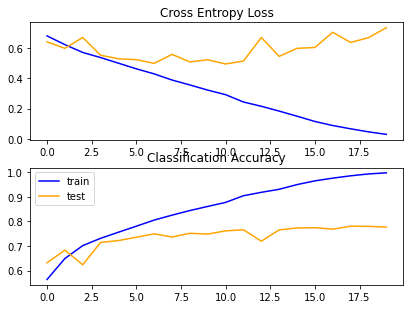

Train Loss: 14.668323516845703; Train Accuracy: 0.9493749737739563
Test Loss: 190.8042755126953; Test Accuracy: 0.7390000224113464
fold time:  0:01:28.185411
Fold 1
Test Index Start:1000
Test Set Size:1000


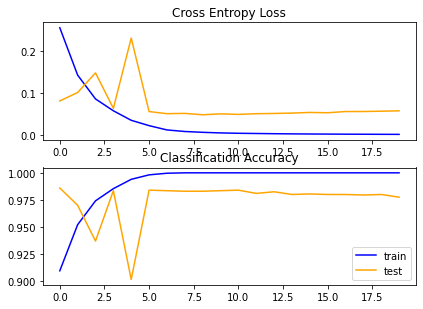

Train Loss: 31.789108276367188; Train Accuracy: 0.9298750162124634
Test Loss: 77.33727264404297; Test Accuracy: 0.8870000243186951
fold time:  0:01:26.559844
Fold 2
Test Index Start:2000
Test Set Size:1000


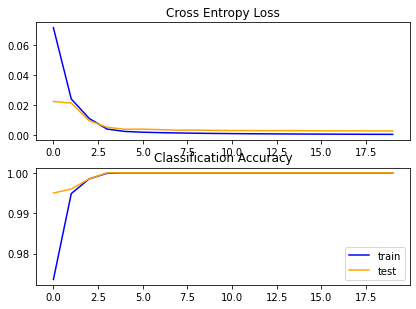

Train Loss: 27.02799415588379; Train Accuracy: 0.9428750276565552
Test Loss: 32.339508056640625; Test Accuracy: 0.9315000176429749
fold time:  0:01:26.722789
Fold 3
Test Index Start:3000
Test Set Size:1000


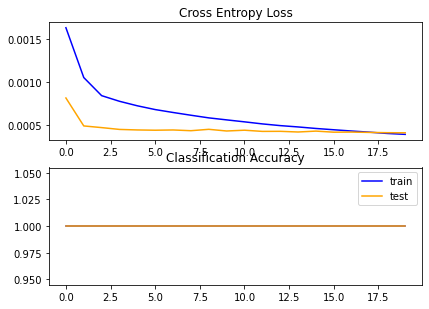

Train Loss: 29.734071731567383; Train Accuracy: 0.9417499899864197
Test Loss: 28.294157028198242; Test Accuracy: 0.9430000185966492
fold time:  0:01:26.527325
Fold 4
Test Index Start:4000
Test Set Size:1000


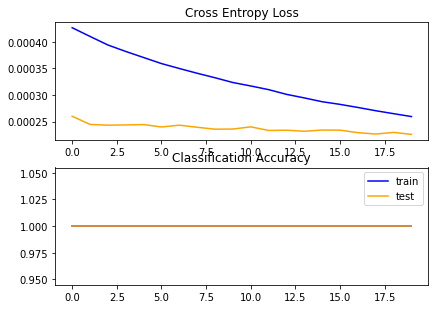

Train Loss: 29.600372314453125; Train Accuracy: 0.9449999928474426
Test Loss: 19.94630241394043; Test Accuracy: 0.9539999961853027
fold time:  0:01:27.389498
0:01:27.076973


In [6]:
print(f"Batch Size: 32")
kfold(network, cat_imgs, dog_imgs, 32)

Batch Size: 64
Fold 0
Test Index Start:0
Test Set Size:1000


2022-03-12 17:36:33.180490: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-12 17:36:35.424783: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


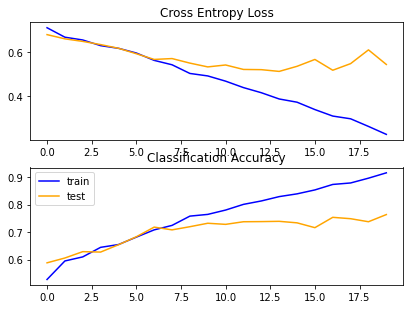

Train Loss: 25.03864097595215; Train Accuracy: 0.8784999847412109
Test Loss: 106.65825653076172; Test Accuracy: 0.7275000214576721
fold time:  0:01:41.265356
Fold 1
Test Index Start:1000
Test Set Size:1000


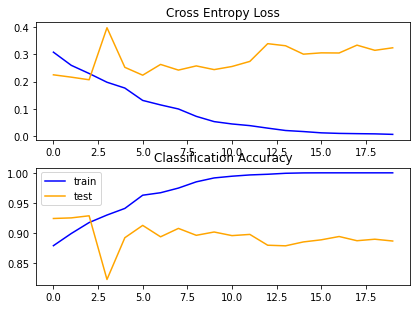

Train Loss: 0.5672159790992737; Train Accuracy: 0.9962499737739563
Test Loss: 79.2214126586914; Test Accuracy: 0.8705000281333923
fold time:  0:01:37.138224
Fold 2
Test Index Start:2000
Test Set Size:1000


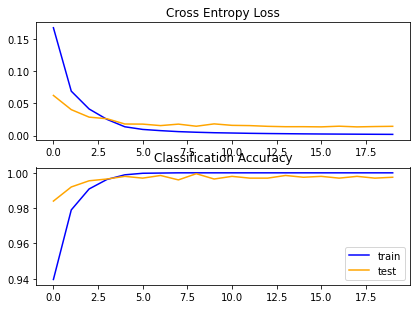

Train Loss: 0.38567471504211426; Train Accuracy: 0.996874988079071
Test Loss: 3.8363726139068604; Test Accuracy: 0.984000027179718
fold time:  0:01:38.589461
Fold 3
Test Index Start:3000
Test Set Size:1000


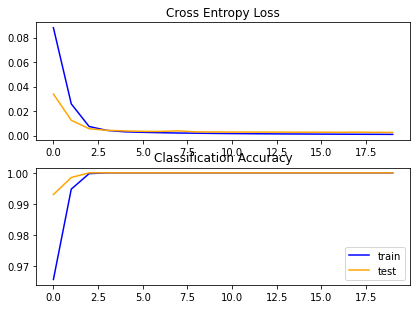

Train Loss: 0.42738890647888184; Train Accuracy: 0.9975000023841858
Test Loss: 2.5170557498931885; Test Accuracy: 0.9915000200271606
fold time:  0:01:36.846740
Fold 4
Test Index Start:4000
Test Set Size:1000


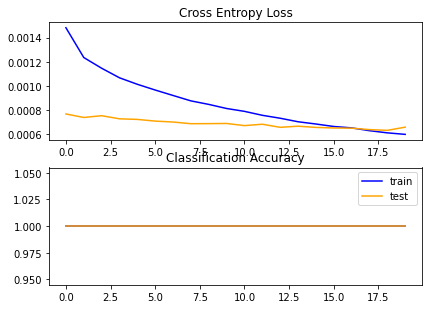

Train Loss: 0.5226514935493469; Train Accuracy: 0.9971250295639038
Test Loss: 0.29369890689849854; Test Accuracy: 0.9984999895095825
fold time:  0:01:37.425816
0:01:38.253119


In [5]:
print(f"Batch Size: 64")
kfold(network, cat_imgs, dog_imgs, 64)

Batch Size: 128
Fold 0
Test Index Start:0
Test Set Size:1000


2022-03-12 17:52:12.706240: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-12 17:52:15.305053: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


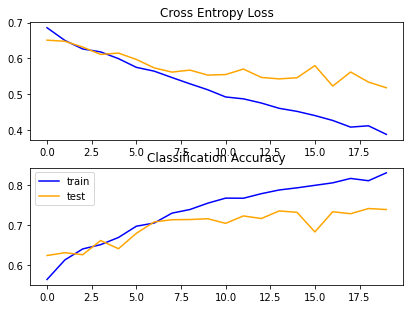

Train Loss: 79.38953399658203; Train Accuracy: 0.7092499732971191
Test Loss: 111.49783325195312; Test Accuracy: 0.6504999995231628
fold time:  0:01:42.025367
Fold 1
Test Index Start:1000
Test Set Size:1000


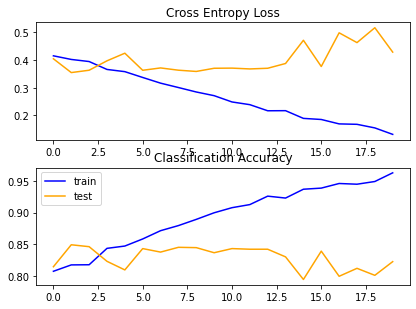

Train Loss: 31.407241821289062; Train Accuracy: 0.8631250262260437
Test Loss: 116.44733428955078; Test Accuracy: 0.7549999952316284
fold time:  0:01:35.740748
Fold 2
Test Index Start:2000
Test Set Size:1000


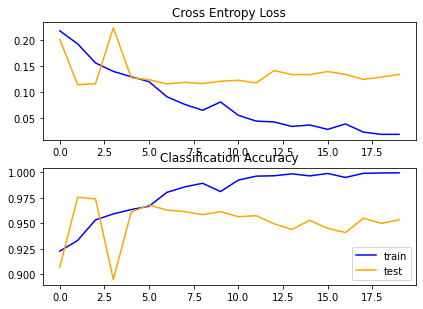

Train Loss: 2.570267915725708; Train Accuracy: 0.984499990940094
Test Loss: 29.94107437133789; Test Accuracy: 0.9139999747276306
fold time:  0:01:36.518280
Fold 3
Test Index Start:3000
Test Set Size:1000


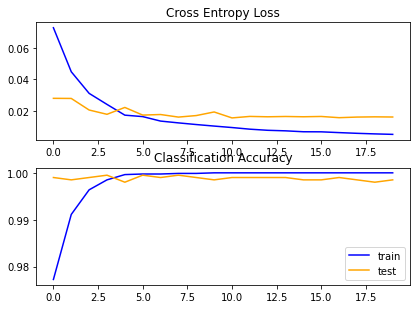

Train Loss: 4.403171062469482; Train Accuracy: 0.9772499799728394
Test Loss: 14.739559173583984; Test Accuracy: 0.953499972820282
fold time:  0:01:31.849420
Fold 4
Test Index Start:4000
Test Set Size:1000


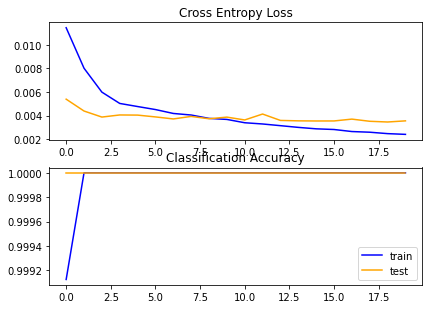

Train Loss: 3.196727991104126; Train Accuracy: 0.984250009059906
Test Loss: 4.310000419616699; Test Accuracy: 0.9804999828338623
fold time:  0:01:26.202092
0:01:34.467181


In [5]:
print(f"Batch Size: 128")
kfold(network, cat_imgs, dog_imgs, 128)

Batch Size: 256
Fold 0
Test Index Start:0
Test Set Size:1000


2022-03-12 18:15:15.897340: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-12 18:15:18.240108: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


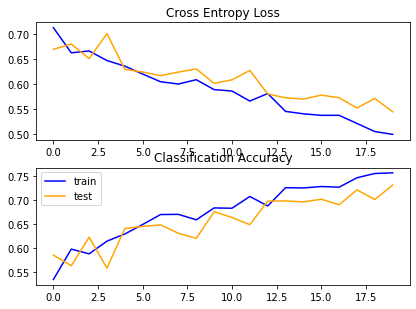

Train Loss: 44.36127471923828; Train Accuracy: 0.7350000143051147
Test Loss: 57.03873062133789; Test Accuracy: 0.6850000023841858
fold time:  0:01:39.233545
Fold 1
Test Index Start:1000
Test Set Size:1000


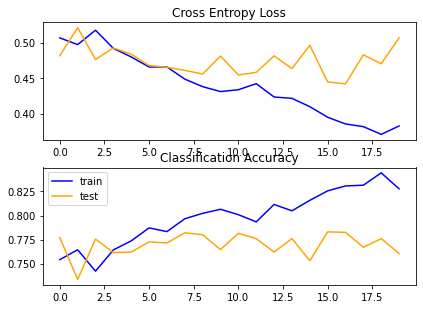

Train Loss: 29.54934310913086; Train Accuracy: 0.8475000262260437
Test Loss: 49.90593338012695; Test Accuracy: 0.7754999995231628
fold time:  0:01:34.555867
Fold 2
Test Index Start:2000
Test Set Size:1000


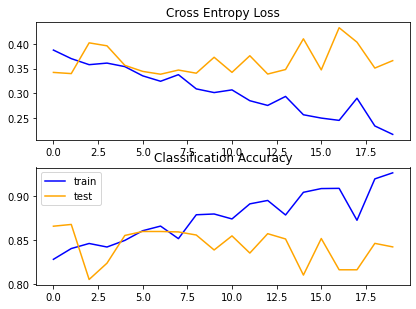

Train Loss: 39.163387298583984; Train Accuracy: 0.8299999833106995
Test Loss: 78.29755401611328; Test Accuracy: 0.7695000171661377
fold time:  0:01:34.351608
Fold 3
Test Index Start:3000
Test Set Size:1000


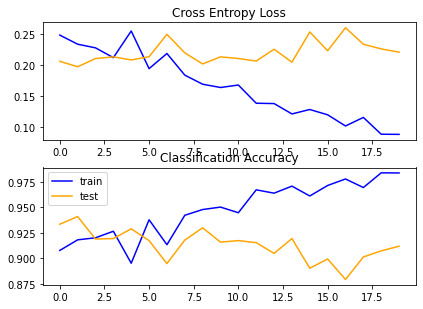

Train Loss: 3.951371192932129; Train Accuracy: 0.971875011920929
Test Loss: 33.420223236083984; Test Accuracy: 0.8899999856948853
fold time:  0:01:33.987556
Fold 4
Test Index Start:4000
Test Set Size:1000


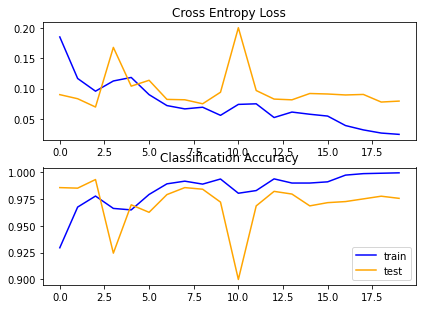

Train Loss: 1.5284746885299683; Train Accuracy: 0.9869999885559082
Test Loss: 18.22281265258789; Test Accuracy: 0.9279999732971191
fold time:  0:01:35.485475
0:01:35.522810


In [5]:
print(f"Batch Size: 256")
kfold(network, cat_imgs, dog_imgs, 256)

Batch Size: 512
Fold 0
Test Index Start:0
Test Set Size:1000


2022-03-12 18:40:23.625207: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-12 18:40:24.817413: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


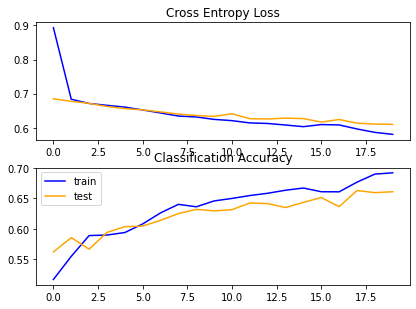

Train Loss: 34.0327033996582; Train Accuracy: 0.7016249895095825
Test Loss: 42.20740509033203; Test Accuracy: 0.6639999747276306
fold time:  0:01:40.607666
Fold 1
Test Index Start:1000
Test Set Size:1000


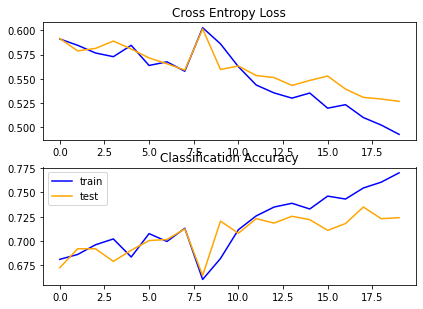

Train Loss: 37.24361801147461; Train Accuracy: 0.7556250095367432
Test Loss: 46.36136245727539; Test Accuracy: 0.7124999761581421
fold time:  0:01:37.201131
Fold 2
Test Index Start:2000
Test Set Size:1000


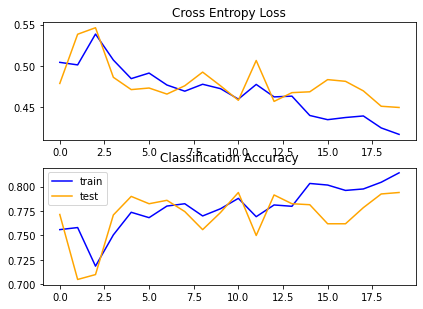

Train Loss: 33.633567810058594; Train Accuracy: 0.8042500019073486
Test Loss: 43.97264862060547; Test Accuracy: 0.7795000076293945
fold time:  0:01:35.543779
Fold 3
Test Index Start:3000
Test Set Size:1000


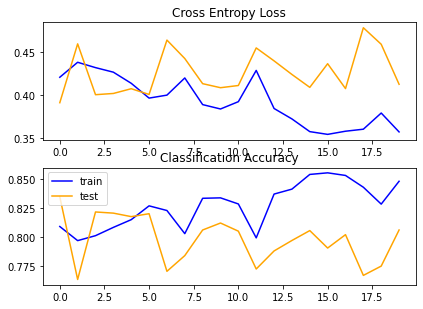

Train Loss: 34.15730285644531; Train Accuracy: 0.8234999775886536
Test Loss: 53.530399322509766; Test Accuracy: 0.7795000076293945
fold time:  0:01:35.760956
Fold 4
Test Index Start:4000
Test Set Size:1000


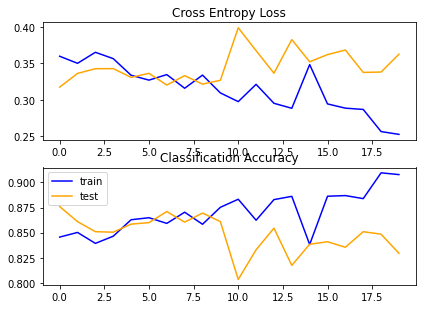

Train Loss: 34.705528259277344; Train Accuracy: 0.8402500152587891
Test Loss: 62.432857513427734; Test Accuracy: 0.781000018119812
fold time:  0:01:35.736897
0:01:36.970086


In [5]:
print(f"Batch Size: 512")
kfold(network, cat_imgs, dog_imgs, 512)

In [ ]:
print(f"Batch Size: 1024")
kfold(network, cat_imgs, dog_imgs, 1024)

BEST BATCH SIZE: 32

## EXPERIMENT 2: OPTIMIZER

Fold 0
Test Index Start:0
Test Set Size:1000


2022-03-12 18:53:06.641478: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-12 18:53:07.466125: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


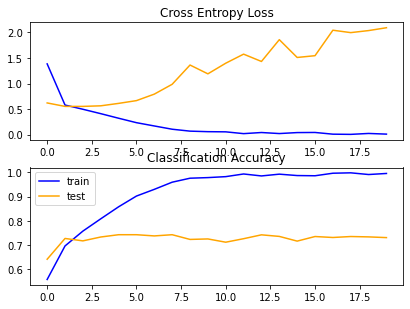

Train Loss: 22.551570892333984; Train Accuracy: 0.968999981880188
Test Loss: 452.5854187011719; Test Accuracy: 0.7085000276565552
fold time:  0:01:27.014568
Fold 1
Test Index Start:1000
Test Set Size:1000


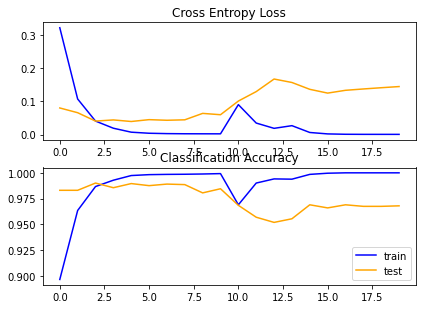

Train Loss: 46.7128791809082; Train Accuracy: 0.9601250290870667
Test Loss: 107.75827026367188; Test Accuracy: 0.921500027179718
fold time:  0:01:24.934001
Fold 2
Test Index Start:2000
Test Set Size:1000


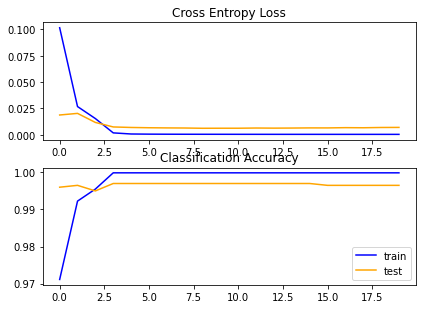

Train Loss: 54.645633697509766; Train Accuracy: 0.9598749876022339
Test Loss: 68.14055633544922; Test Accuracy: 0.9549999833106995
fold time:  0:01:25.480101
Fold 3
Test Index Start:3000
Test Set Size:1000


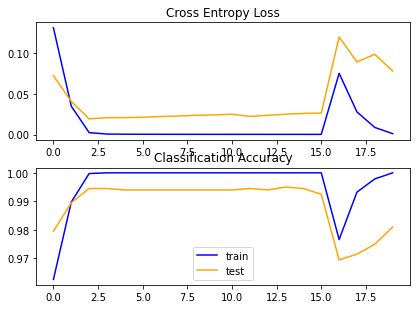

Train Loss: 53.46332550048828; Train Accuracy: 0.9445000290870667
Test Loss: 118.84662628173828; Test Accuracy: 0.9079999923706055
fold time:  0:01:25.260048
Fold 4
Test Index Start:4000
Test Set Size:1000


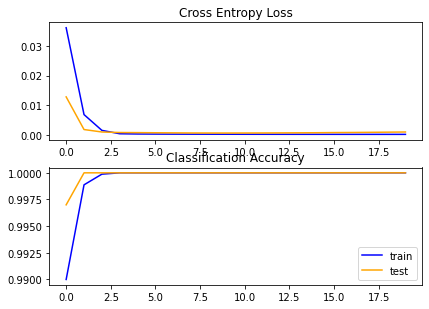

Train Loss: 65.52459716796875; Train Accuracy: 0.9557499885559082
Test Loss: 65.18108367919922; Test Accuracy: 0.9495000243186951
fold time:  0:01:25.986307
0:01:25.735005


In [5]:
opt = Adam()
network = build_network()
network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
kfold(network, cat_imgs, dog_imgs, 32)

Fold 0
Test Index Start:0
Test Set Size:1000


2022-03-12 19:07:58.758370: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-12 19:08:00.851929: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


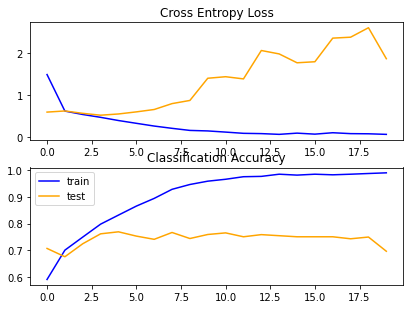

Train Loss: 60.11627960205078; Train Accuracy: 0.8821250200271606
Test Loss: 418.0798034667969; Test Accuracy: 0.675000011920929
fold time:  0:01:32.674393
Fold 1
Test Index Start:1000
Test Set Size:1000


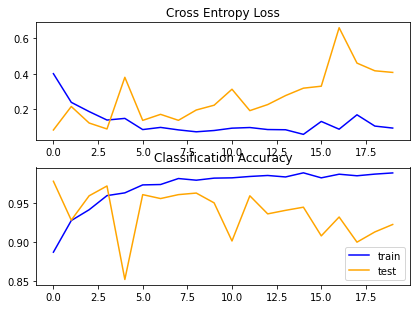

Train Loss: 49.96826171875; Train Accuracy: 0.9673749804496765
Test Loss: 274.9520263671875; Test Accuracy: 0.8705000281333923
fold time:  0:01:29.249533
Fold 2
Test Index Start:2000
Test Set Size:1000


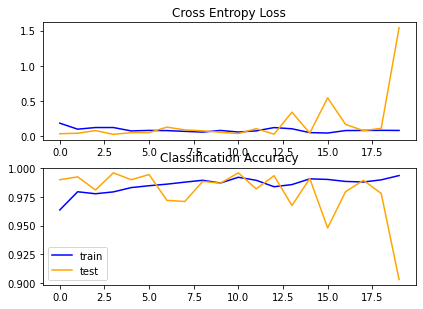

Train Loss: 331.933349609375; Train Accuracy: 0.9227499961853027
Test Loss: 478.6333923339844; Test Accuracy: 0.8955000042915344
fold time:  0:01:29.035942
Fold 3
Test Index Start:3000
Test Set Size:1000


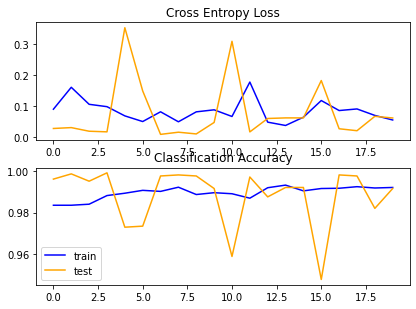

Train Loss: 73.9416275024414; Train Accuracy: 0.9787499904632568
Test Loss: 160.57583618164062; Test Accuracy: 0.9660000205039978
fold time:  0:01:29.809343
Fold 4
Test Index Start:4000
Test Set Size:1000


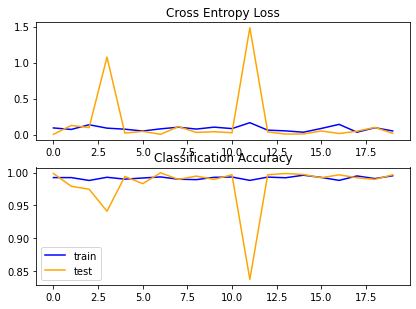

Train Loss: 54.52168655395508; Train Accuracy: 0.9893749952316284
Test Loss: 46.15166473388672; Test Accuracy: 0.987500011920929
fold time:  0:01:29.425947
0:01:30.039032


In [5]:
opt = RMSprop()
network = build_network()
network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
kfold(network, cat_imgs, dog_imgs, 32)

BEST OPTIMIZER: SGD

## EXPERIMENT 3: LEARNING RATE

In [ ]:
for lr in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
    print("Learning Rate: ", lr)
    opt = SGD(learning_rate=lr, momentum=0.9)
    network = build_network()
    network.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    kfold(network, cat_imgs, dog_imgs, 32)

```
Learning Rate:  0.0001
Fold 0
Test Index Start:0
Test Set Size:1000
Train Loss: 69.54759979248047; Train Accuracy: 0.7003750205039978
Test Loss: 89.89476013183594; Test Accuracy: 0.656000018119812
fold time:  0:01:34.404944
Fold 1
Test Index Start:1000
Test Set Size:1000
Train Loss: 47.712364196777344; Train Accuracy: 0.7851250171661377
Test Loss: 77.77570343017578; Test Accuracy: 0.7285000085830688
fold time:  0:01:25.651987
Fold 2
Test Index Start:2000
Test Set Size:1000
Train Loss: 39.505123138427734; Train Accuracy: 0.8240000009536743
Test Loss: 74.06734466552734; Test Accuracy: 0.781000018119812
fold time:  0:01:28.689638
Fold 3
Test Index Start:3000
Test Set Size:1000
Train Loss: 10.339767456054688; Train Accuracy: 0.9337499737739563
Test Loss: 42.38047790527344; Test Accuracy: 0.8650000095367432
fold time:  0:01:36.528761
Fold 4
Test Index Start:4000
Test Set Size:1000
Train Loss: 4.25724983215332; Train Accuracy: 0.9695000052452087
Test Loss: 22.5677547454834; Test Accuracy: 0.9225000143051147
fold time:  0:01:37.529787
0:01:32.561023
```

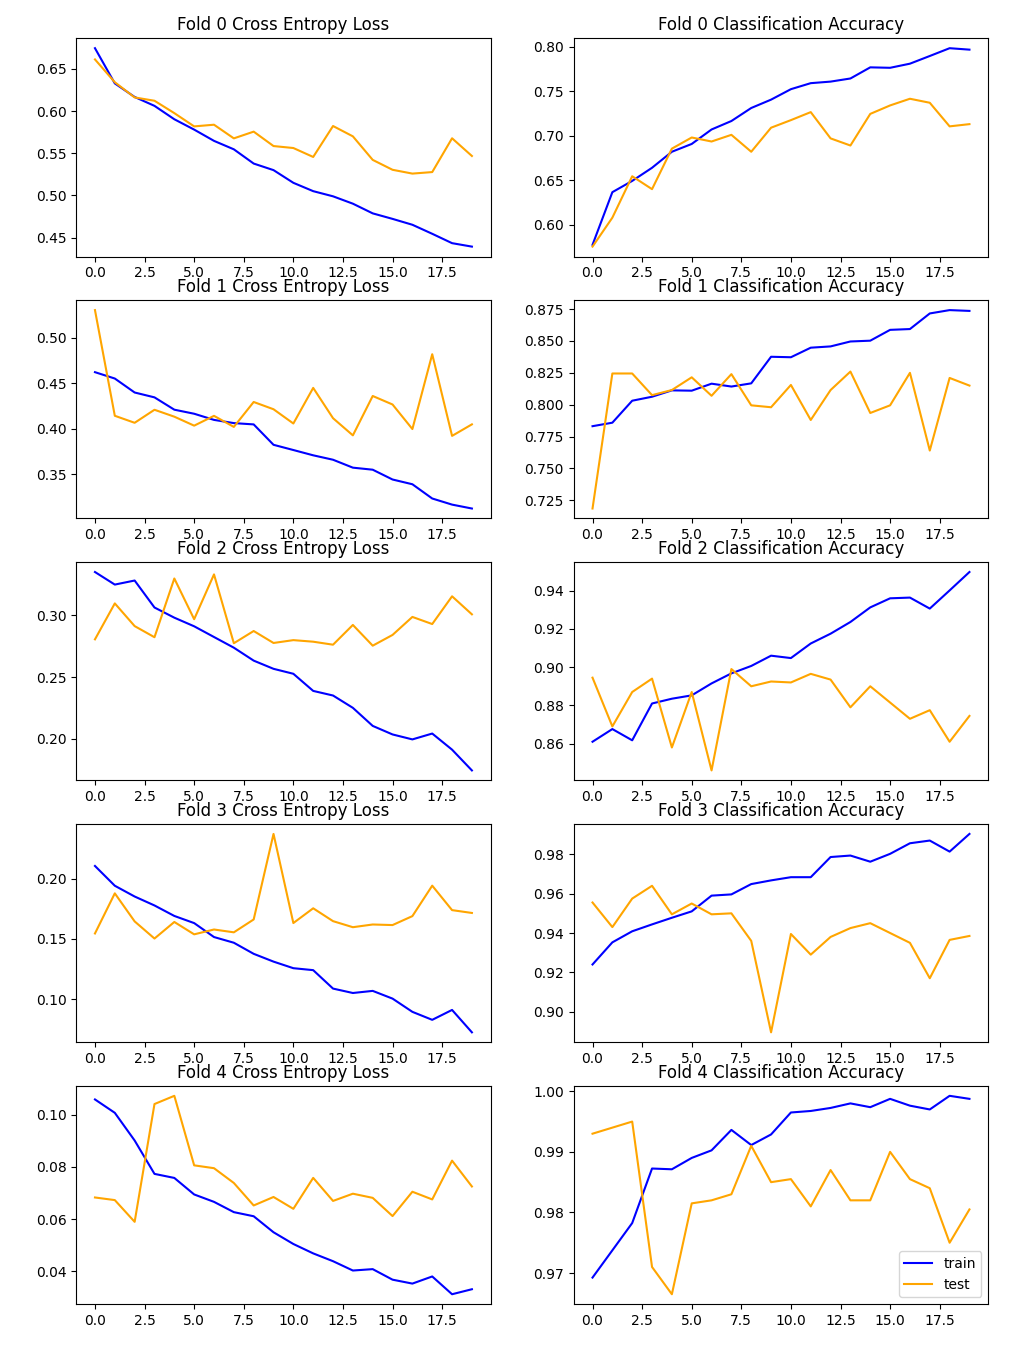

In [9]:
Image(filename='img/lr=0.0001.png')

```
Learning Rate:  0.0005
Fold 0
Test Index Start:0
Test Set Size:1000
Train Loss: 28.89767837524414; Train Accuracy: 0.875374972820282
Test Loss: 153.4326629638672; Test Accuracy: 0.7149999737739563
fold time:  0:01:39.500675
Fold 1
Test Index Start:1000
Test Set Size:1000
Train Loss: 0.05671617016196251; Train Accuracy: 0.999750018119812
Test Loss: 42.32884979248047; Test Accuracy: 0.9144999980926514
fold time:  0:01:34.344134
Fold 2
Test Index Start:2000
Test Set Size:1000
Train Loss: 0.18704776465892792; Train Accuracy: 0.9992499947547913
Test Loss: 1.2608239650726318; Test Accuracy: 0.9915000200271606
fold time:  0:01:33.897753
Fold 3
Test Index Start:3000
Test Set Size:1000
Train Loss: 0.11482257395982742; Train Accuracy: 0.9991250038146973
Test Loss: 0.03573989123106003; Test Accuracy: 0.9994999766349792
fold time:  0:01:34.672659
Fold 4
Test Index Start:4000
Test Set Size:1000
Train Loss: 0.059725549072027206; Train Accuracy: 0.999625027179718
Test Loss: 0.10170065611600876; Test Accuracy: 0.9990000128746033
fold time:  0:01:35.155087
```

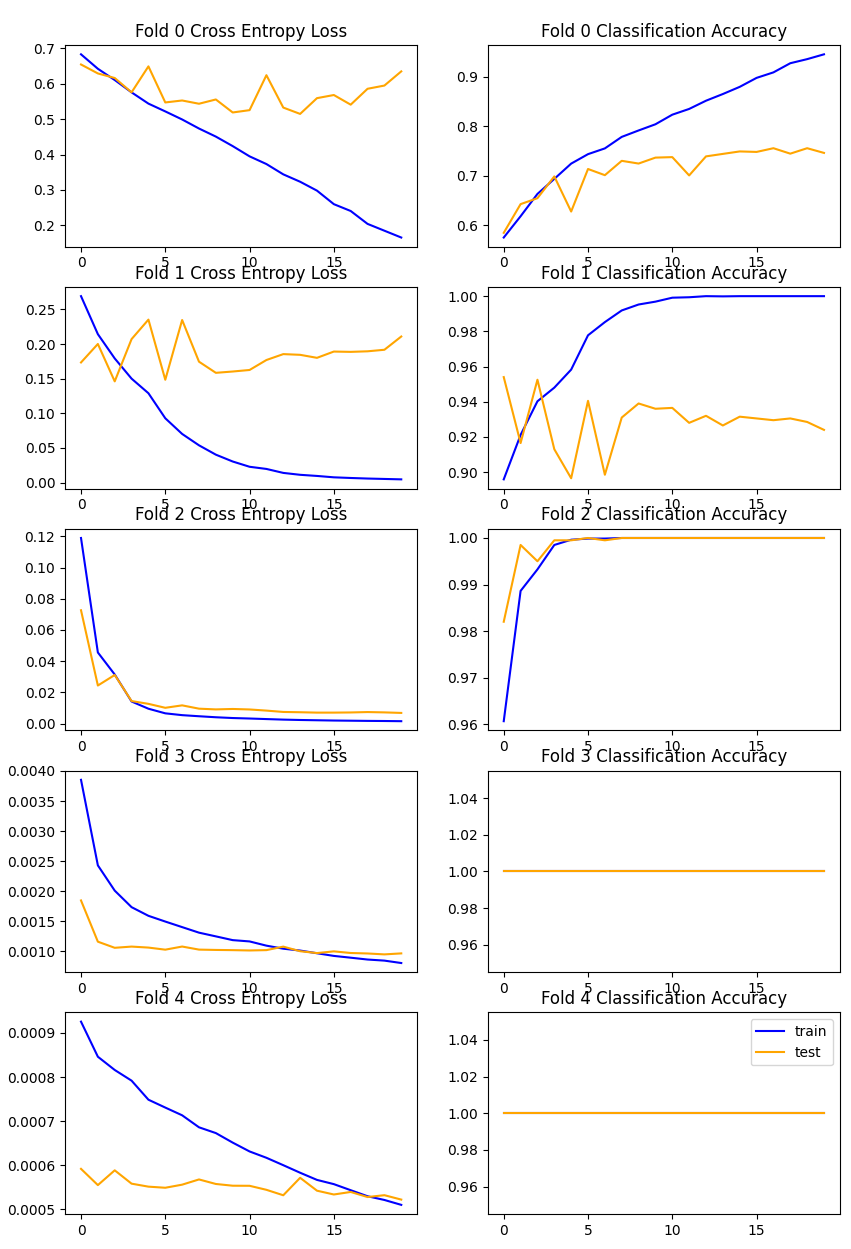

In [10]:
Image(filename='img/lr=0.0005.png')

```
Learning Rate:  0.001
Fold 0
Test Index Start:0
Test Set Size:1000
Train Loss: 8.438940048217773; Train Accuracy: 0.9658750295639038
Test Loss: 199.3184051513672; Test Accuracy: 0.734499990940094
fold time:  0:01:40.830007
Fold 1
Test Index Start:1000
Test Set Size:1000
Train Loss: 8.19058609008789; Train Accuracy: 0.9750000238418579
Test Loss: 43.477298736572266; Test Accuracy: 0.921500027179718
fold time:  0:01:35.490050
Fold 2
Test Index Start:2000
Test Set Size:1000
Train Loss: 9.283992767333984; Train Accuracy: 0.9752500057220459
Test Loss: 10.090091705322266; Test Accuracy: 0.9695000052452087
fold time:  0:01:35.644523
Fold 3
Test Index Start:3000
Test Set Size:1000
Train Loss: 9.251498222351074; Train Accuracy: 0.9754999876022339
Test Loss: 7.880189418792725; Test Accuracy: 0.9775000214576721
fold time:  0:01:35.912357
Fold 4
Test Index Start:4000
Test Set Size:1000
Train Loss: 10.951847076416016; Train Accuracy: 0.9736250042915344
Test Loss: 6.061832427978516; Test Accuracy: 0.9835000038146973
fold time:  0:01:35.955473
```

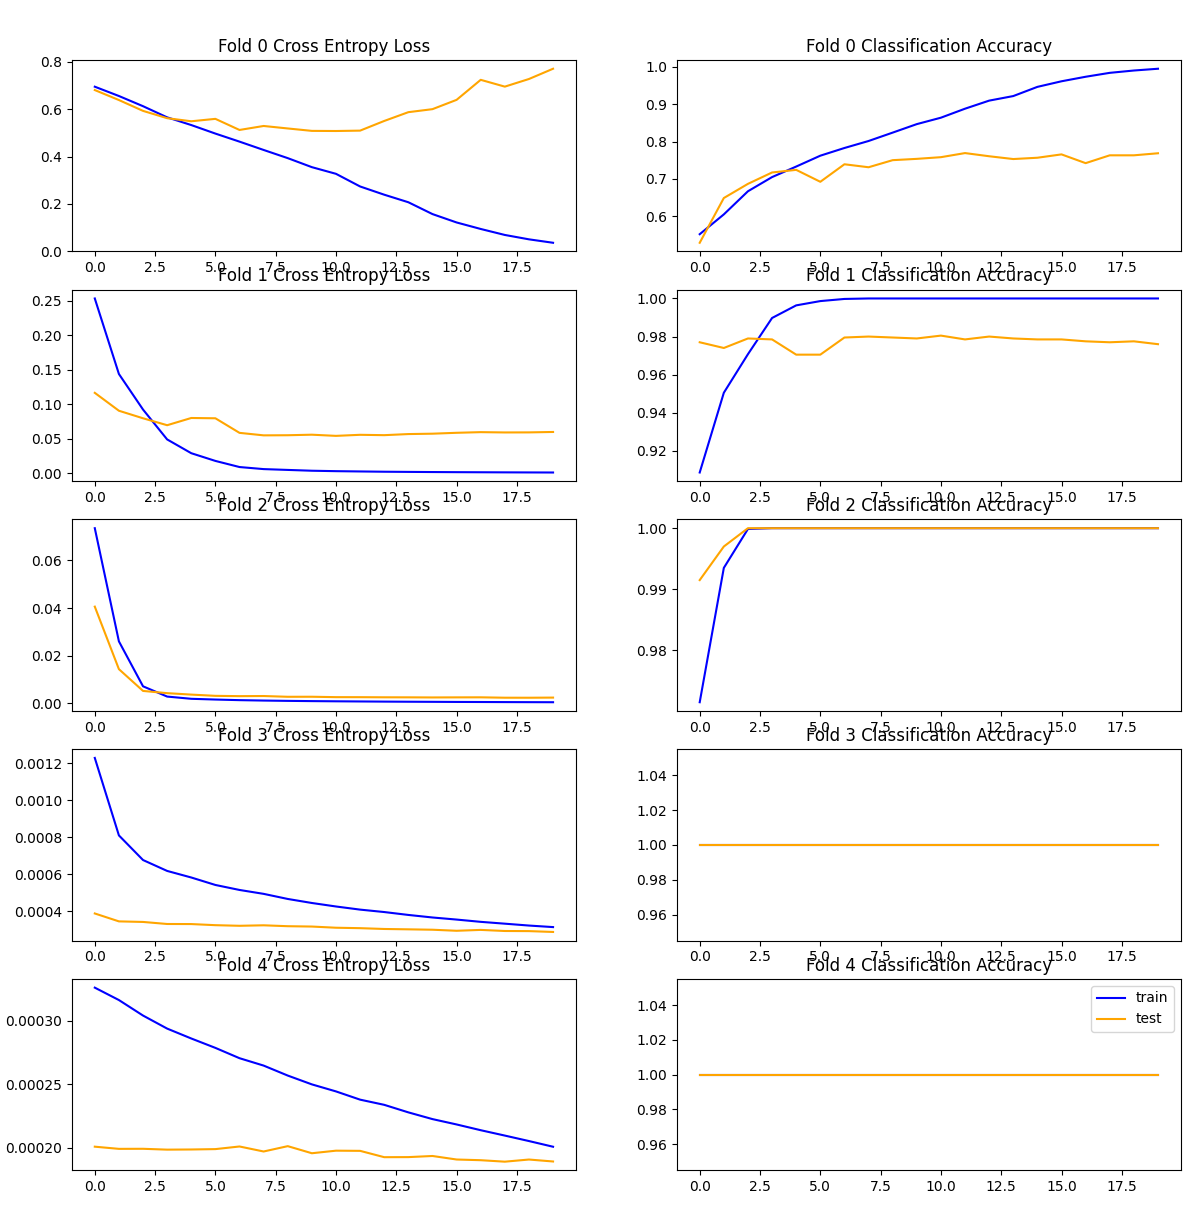

In [13]:
Image(filename='img/lr=0.001.png')

```
Learning Rate:  0.005
Fold 0
Test Index Start:0
Test Set Size:1000
Train Loss: 46.837589263916016; Train Accuracy: 0.9288750290870667
Test Loss: 457.0392150878906; Test Accuracy: 0.7135000228881836
fold time:  0:01:39.699936
Fold 1
Test Index Start:1000
Test Set Size:1000
Train Loss: 40.98460388183594; Train Accuracy: 0.9440000057220459
Test Loss: 88.9300308227539; Test Accuracy: 0.9020000100135803
fold time:  0:01:35.867585
Fold 2
Test Index Start:2000
Test Set Size:1000
Train Loss: 54.716796875; Train Accuracy: 0.9278749823570251
Test Loss: 71.39598846435547; Test Accuracy: 0.9164999723434448
fold time:  0:01:35.556473
Fold 3
Test Index Start:3000
Test Set Size:1000
Train Loss: 41.80899429321289; Train Accuracy: 0.9477499723434448
Test Loss: 74.19831085205078; Test Accuracy: 0.9309999942779541
fold time:  0:01:36.677509
Fold 4
Test Index Start:4000
Test Set Size:1000
Train Loss: 75.1180648803711; Train Accuracy: 0.9229999780654907
Test Loss: 72.35572814941406; Test Accuracy: 0.9194999933242798
fold time:  0:01:36.085671
```

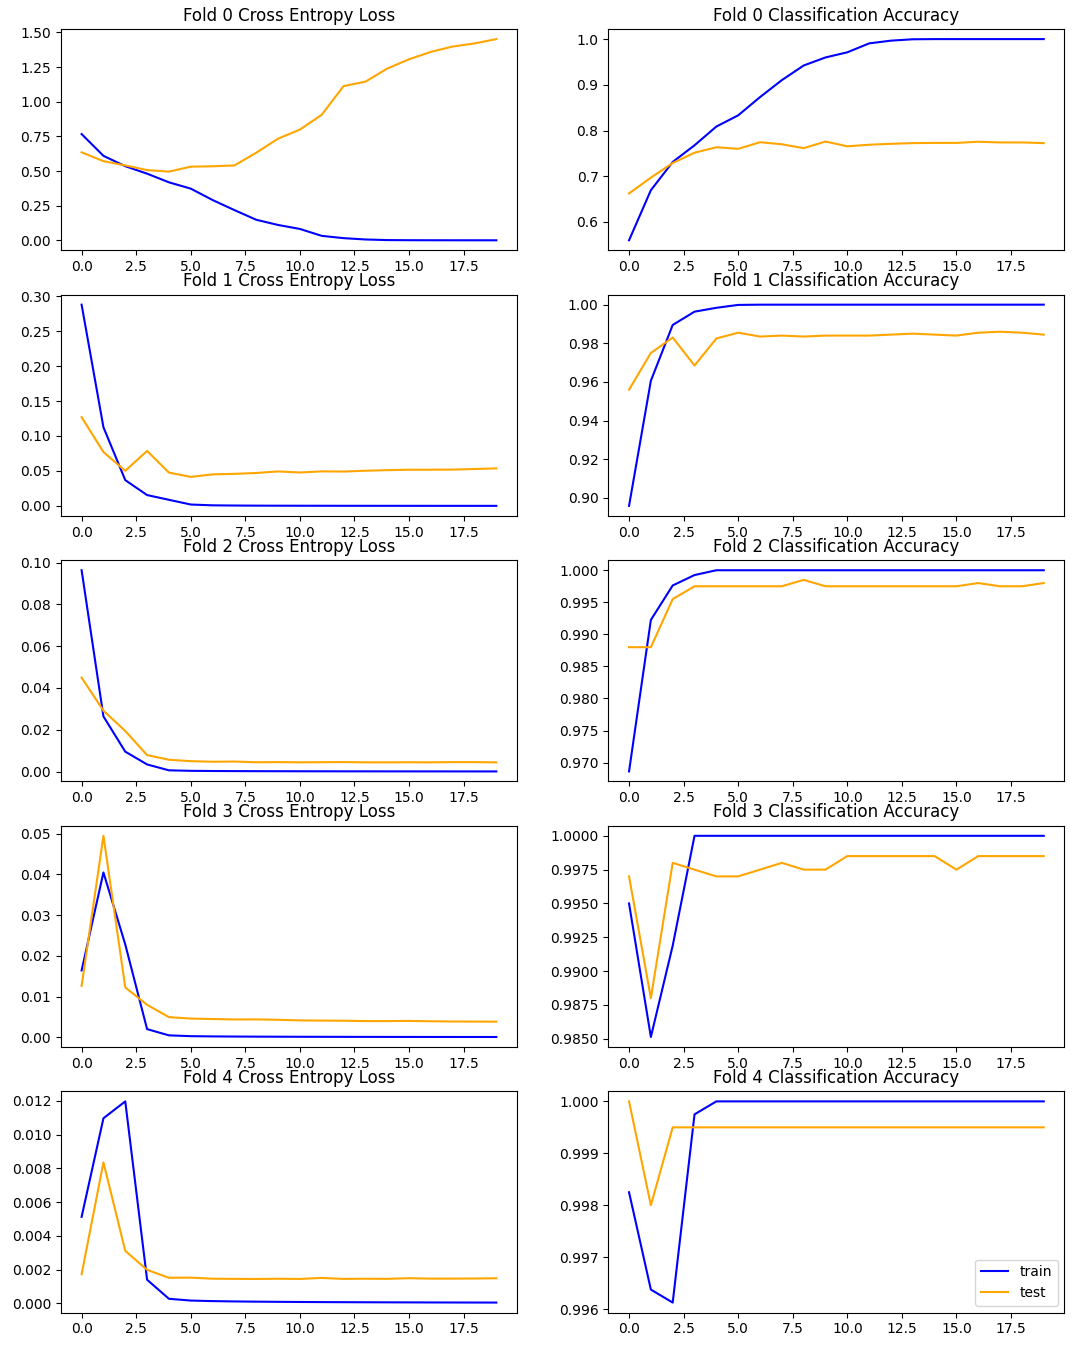

In [14]:
Image(filename='img/lr=0.005.png')

````
Learning Rate:  0.01
Fold 0
Test Index Start:0
Test Set Size:1000
2022-03-12 23:39:25.972747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-12 23:39:26.394534: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-12 23:39:26.876055: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Train Loss: 83.09467315673828; Train Accuracy: 0.9026250243186951
Test Loss: 548.4327392578125; Test Accuracy: 0.7080000042915344
fold time:  0:01:37.193229
Fold 1
Test Index Start:1000
Test Set Size:1000
Train Loss: 131.16165161132812; Train Accuracy: 0.8631250262260437
Test Loss: 192.8739013671875; Test Accuracy: 0.8420000076293945
fold time:  0:01:35.722833
Fold 2
Test Index Start:2000
Test Set Size:1000
Train Loss: 51.09066390991211; Train Accuracy: 0.937125027179718
Test Loss: 60.75957107543945; Test Accuracy: 0.9279999732971191
fold time:  0:01:35.273759
Fold 3
Test Index Start:3000
Test Set Size:1000
Train Loss: 57.34739685058594; Train Accuracy: 0.9313750267028809
Test Loss: 64.77613067626953; Test Accuracy: 0.9309999942779541
fold time:  0:01:35.073372
Fold 4
Test Index Start:4000
Test Set Size:1000
Train Loss: 57.8859977722168; Train Accuracy: 0.937375009059906
Test Loss: 38.61709213256836; Test Accuracy: 0.9459999799728394
fold time:  0:01:35.333041
````

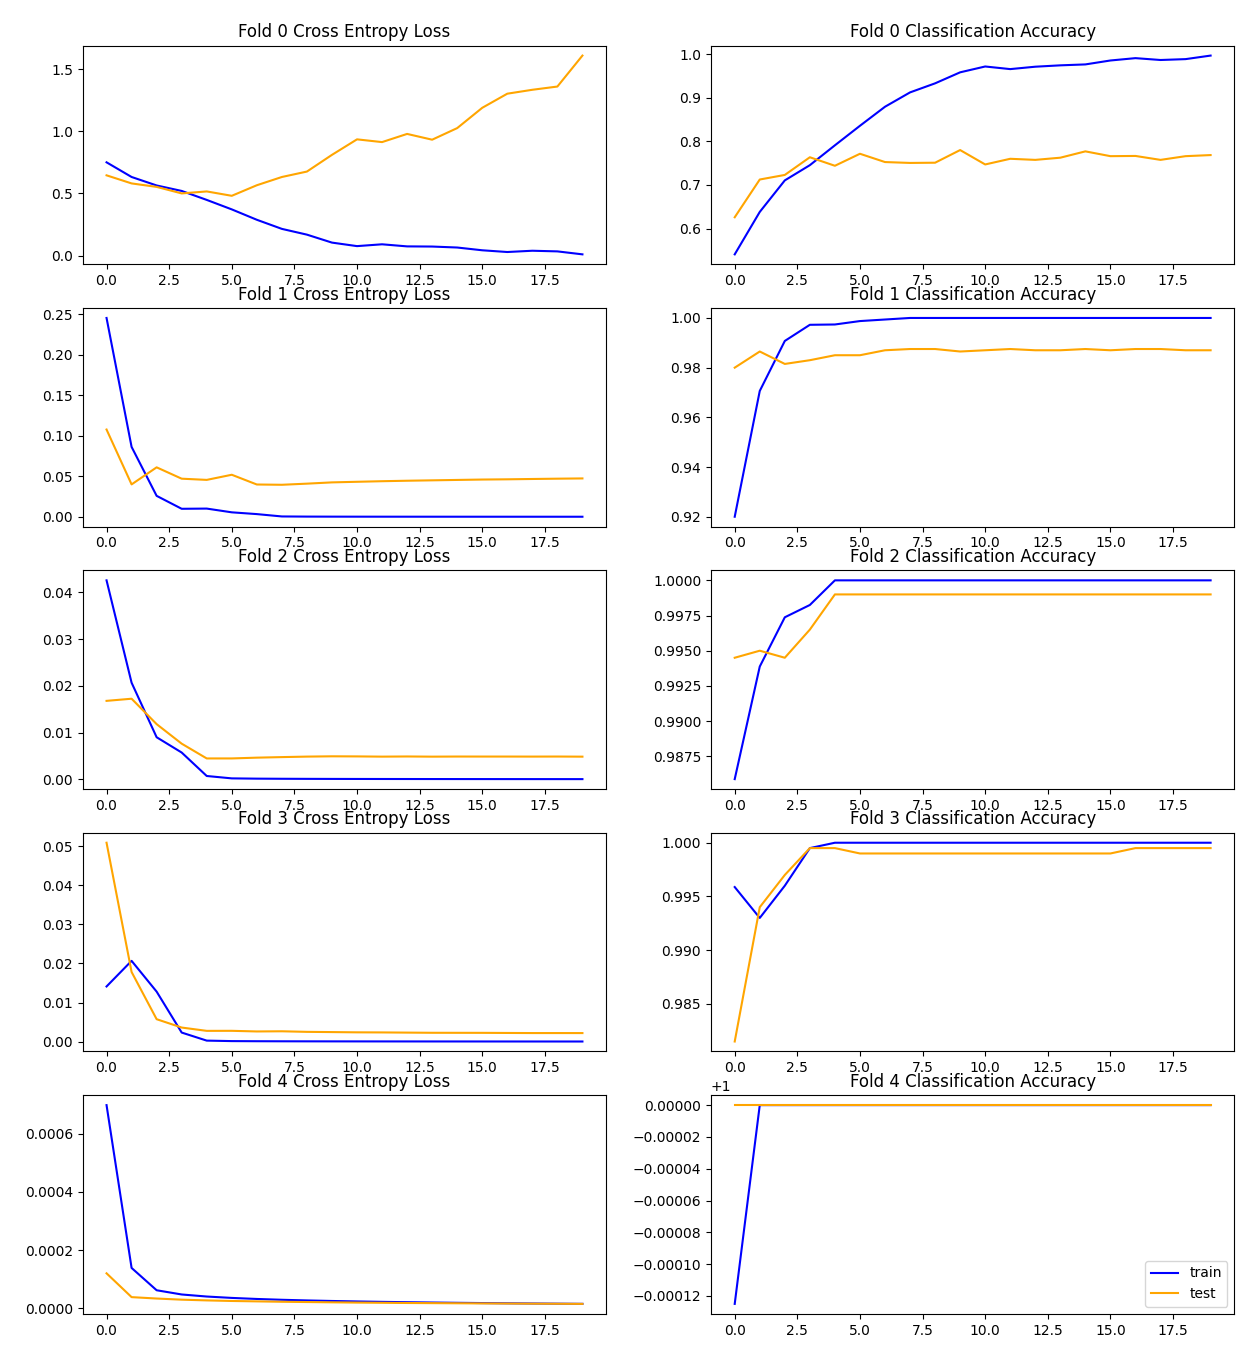

In [15]:
Image(filename='img/lr=0.01.png')

BEST LEARNING RATE: 0.0005

Ideal # of Epochs: 4 (begins to overfit after in some folds)